# Reconfigurable FFT

## Overlay Setup

In [1]:
from pynq import Overlay

In [2]:
overlay = Overlay("FFT_Reconfig.bit")

In [20]:
overlay?

In [4]:
data_dma = overlay.fft_block.data_dma
config_dma = overlay.fft_block.config_dma

In [5]:
config_dma?

In [6]:
data_send = data_dma.sendchannel
data_recv = data_dma.recvchannel
config_send = config_dma.sendchannel

## Creating Config

https://www.xilinx.com/support/documents/ip_documentation/xfft/v9_1/pg109-xfft.pdf   (Runtime Transform Configuration)

![alt text](Config_FFT.png "Subheading")

In [7]:
from math import log
def get_config_data(fft_direction, size):
    fft_direction.zfill(8)
    
    byte2 = '0'*8 #No cyclic Prefix
    
    expo = int(log(size,2))
    fft_size_bin = bin(expo)[2:]
    
    fft_size_bin.zfill(8)
    config_data = fft_direction + byte2 + fft_size_bin
    return int(config_data,2)

## Data Generation

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [9]:
def get_random_data(SAMPLES, time_interval):
    A1 = random.uniform(100,1000)
    A2 = random.uniform(100,1000)
    A3 = random.uniform(100,1000)
    f1 = random.uniform(100,180)
    f2 = random.uniform(200,480)
    f3 = random.uniform(500,1500)
    w1 = 2*np.pi*f1
    w2 = 2*np.pi*f2
    w3 = 2*np.pi*f3
    t = np.linspace(0, time_interval, SAMPLES)
    data = A1*np.sin(w1*t,dtype=np.csingle) + A2*np.sin(w2*t,dtype=np.csingle) + A3*np.sin(w3*t,dtype=np.csingle)
    return (data,t)
    

In [32]:
SAMPLES = 8192
time_interval = 1

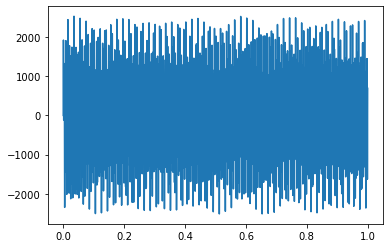

In [33]:
data,t = get_random_data(SAMPLES, time_interval)
plt.plot(t, np.real(data))

## PS Execution

In [48]:
%%time
output = np.fft.fft(data)

CPU times: user 6.88 ms, sys: 377 µs, total: 7.26 ms
Wall time: 4.88 ms


In [41]:
freq = np.fft.fftfreq(SAMPLES*time_interval, 1/SAMPLES)

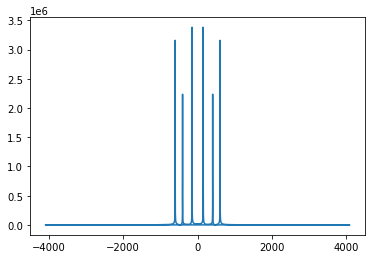

In [36]:
plt.plot(freq, np.abs(output))

## PL Implementation

In [12]:
from pynq import allocate

In [38]:
input_buffer = allocate(SAMPLES, np.csingle)
output_buffer = allocate(SAMPLES, np.csingle)
np.copyto(input_buffer,data)

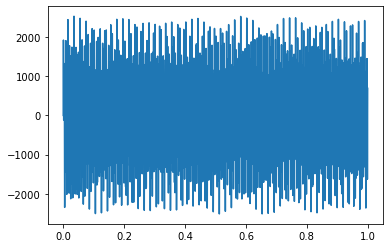

In [39]:
plt.plot(t, np.real(input_buffer))

In [54]:
%%time
data_send.transfer(input_buffer)
data_recv.transfer(output_buffer)
data_send.wait()
data_recv.wait()

CPU times: user 2.19 ms, sys: 121 µs, total: 2.31 ms
Wall time: 2.09 ms


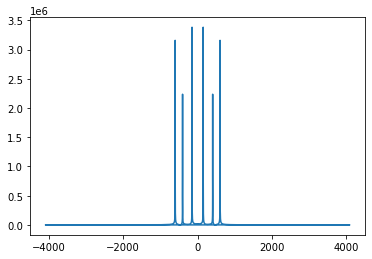

In [55]:
plt.plot(freq, np.abs(output_buffer))

### Using Configuration

In [10]:
SAMPLES = 1024
time_interval = 1
data, t = get_random_data(SAMPLES, time_interval)

In [13]:
config_buffer = allocate(1, np.uint32)
config_buffer[0] = get_config_data('1',SAMPLES)

In [14]:
config_send.transfer(config_buffer)
config_send.wait()

In [15]:
input_buffer1 = allocate(SAMPLES, np.csingle)
output_buffer1 = allocate(SAMPLES, np.csingle)
np.copyto(input_buffer1,data)

In [16]:
data_send.transfer(input_buffer1)
data_recv.transfer(output_buffer1)
data_send.wait()
data_recv.wait()

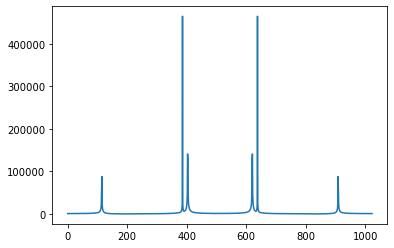

In [17]:
plt.plot(np.abs(output_buffer1))

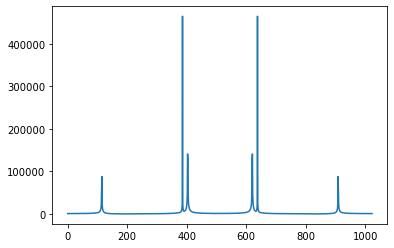

In [18]:
plt.plot(np.abs(np.fft.fft(input_buffer1)))

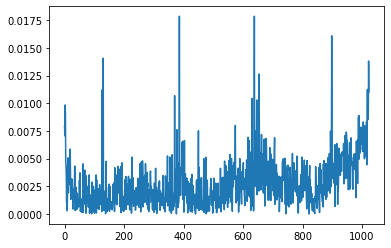

In [19]:
plt.plot(np.abs(np.abs(output_buffer1) - np.abs(np.fft.fft(input_buffer1)))) # ERROR BW PS AND PL